In [ ]:
import pathlib
import pandas as pd
from sklearn.pipeline import make_pipeline 
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from embetter.grab import ColumnGrabber
from embetter.vision import ImageLoader, ColorHistogramEncoder, TimmEncoder

image_emb_pipeline = make_pipeline(
  ColumnGrabber("path"),
  ImageLoader(convert="RGB"),
  TimmEncoder("xception", encode_predictions=True),
)

In [2]:
# Make dataframe with image paths
cat_paths = pathlib.Path("catdog", "cat").glob("*")
dog_paths = pathlib.Path("catdog", "dog").glob("*")

dataf = pd.concat([
    pd.DataFrame({"path": [str(p) for p in cat_paths], "label": "cat"}),
    pd.DataFrame({"path": [str(p) for p in dog_paths], "label": "dog"})
])

# Make csv file with Umap'ed model layer 
X = image_emb_pipeline.fit_transform(dataf)
y = dataf['label'] == "cat"
X.shape

(50, 1000)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def make_model():
    inputs = keras.Input(shape=(None, X.shape[1]))
    x = layers.Dense(50, activation="sigmoid")(inputs)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs), keras.Model(inputs, x)

In [5]:
pred_model, emb_model = make_model()

epochs = 25

pred_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

2022-10-14 16:38:06.909411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-14 16:38:06.909458: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 16:38:06.909497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-10-14 16:38:06.909929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
pred_model.fit(x=X, y=y, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 2ms/step - loss: 0.7149 - accuracy: 0.5200
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.7000
Epoch 3/10
2/2 [==============================] - 0s 2ms/step - loss: 0.6393 - accuracy: 0.7600
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.8400
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.9000
Epoch 6/10
2/2 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.9600
Epoch 7/10
2/2 [==============================] - 0s 2ms/step - loss: 0.5330 - accuracy: 0.9800
Epoch 8/10
2/2 [==============================] - 0s 2ms/step - loss: 0.5113 - accuracy: 0.9800
Epoch 9/10
2/2 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.9600
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 0.4722 - accuracy: 0.9600


In [7]:
# Make dataframe with image paths
paths = pathlib.Path("downloads", "pets").glob("*")
dataf_all = pd.DataFrame({"path": [str(p) for p in paths]})

# Make csv file with Umap'ed model layer 
X_all = image_emb_pipeline.fit_transform(dataf_all)

In [8]:
X_tfm = UMAP().fit_transform(X_all)

In [9]:
X_tfm_fine = UMAP().fit_transform(emb_model.predict(X_all))

16/16 [==============================] - 0s 786us/step


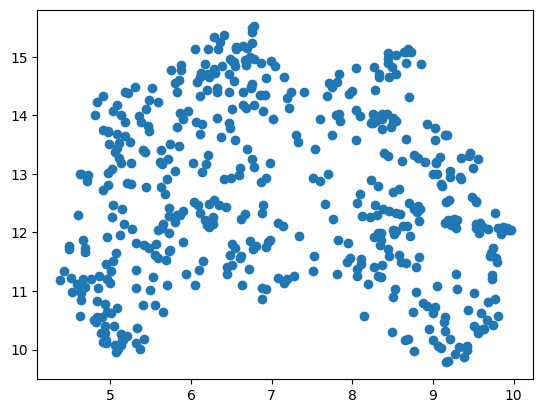

In [10]:
import matplotlib.pylab as plt

plt.scatter(X_tfm[:, 0], X_tfm[:, 1])

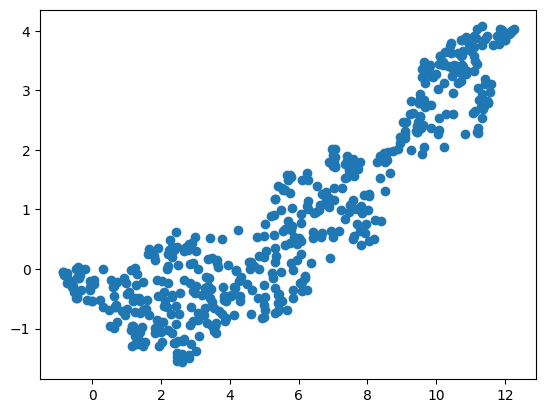

In [11]:
plt.scatter(X_tfm_fine[:, 0], X_tfm_fine[:, 1])

In [13]:
dataf_all.assign(x=X_tfm[:, 0], y=X_tfm[:, 1]).to_csv("pets-orig.csv")
dataf_all.assign(x=X_tfm_fine[:, 0], y=X_tfm_fine[:, 1]).to_csv("pets-finetuned.csv")